In [1]:
pip install tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense



#Grabbing Initial Data
raw_data = pd.read_csv('data.csv')
#print(raw_data.head())



"""
#Plotting initial data
plt.figure(figsize=(20,10)) #size of window
plt.title('Plotting Original Data')
plt.xlabel('Dates')
plt.ylabel('Dollars')
plt.plot(raw_data['time'], raw_data['close']) #plotting data by columns
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365)) #sets location of major tickers on x axis by intervals
plt.gcf().autofmt_xdate()
plt.show()
"""



#Preprocessing the Data
raw_close_data = raw_data['close'].values #1D Array
scaler = MinMaxScaler(feature_range=(0,1)) #setting up the scaler to work between 0 and 1 for each data point
scaled_data = raw_close_data.reshape(-1,1) #.reshape(-1,1) if feature and .reshape(1, -1)
scaled_data = scaler.fit_transform(scaled_data) #transforming the data into 0 to 1 for standarization 
scaled_data = pd.DataFrame(scaled_data, index = raw_data['time']) #making scaled Data into a 2D array by adding timestamps



#Prepare the training set
train_data, test_data = train_test_split(scaled_data, test_size = 0.2, random_state=42) #spits data into to and randomizes order for better training



"""
#Checking to see the data is split 
plt.figure(figsize=(20, 10)) #size of window
plt.title('Plotting Test/Training Split Data')
plt.plot(train_data, color = 'blue') #plotting the train_data blue
plt.plot(test_data, color = 'red') #plotting the test_data red
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1825)) #sets location of major tickers on x axis by intervals
plt.gcf().autofmt_xdate()
plt.show()
"""



#Rolling Window to avoid Look-Ahead-Bias
#Splitting the train_data into a input section (time and close price) and a target section (the close we want to predict). 
window_size = 100

#Note on naming conventions: 
#X is capital because it represents a matrix with 2D values of time and value
# #whereas y is just a vector representing just the target values we want to predict
X_train = [] 
y_train = []

for i in range (len(train_data) - window_size): 
    X_window = train_data[i : i + window_size]
    y_target = train_data[i + window_size: i + window_size + 1]

    X_train.append(X_window)
    y_train.append(y_target)

X_train  = np.array(X_train)
y_train = np.array(y_train)




#Reshaping Training Data for LSTM Insertion 

#Typically, for the LSTM, you have to reshape X_train to have the shape (batch_size, timesteps, features) because LSTMs expect a 3D input
#However, you typically do not need to reshape y_train.
#It doesn't need the extra dimension for timesteps because you're predicting a single value for each training sample.
lstm_ready_train_data = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))



#Building LSTM Model
#The hyperparameters to mess with include the density of the LSTM model, the type of loss measurement, and the algorithm for optimizer
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(train_data.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
model.summary()



#Training the model
model.fit(lstm_ready_train_data, y_train, epochs = 11, batch_size = 64)



"""
#Preprocessing the Test Data
lstm_ready_test_data = np.reshape(test_data.shape[0], test_data.shape[1], 1)
"""


#Predicting the Test Data 
predicted_values = model.predict(test_data)



#Converting Test and Predicted Data back into real values from scaled ones
test_data = scaler.inverse_transform(test_data)
predicted_values = scaler.inverse_transform(predicted_values)



#Plotting Actual vs Predicted
plt.figure(figsize=(20, 10))
plt.title('Actual vs. Predicted Data')
plt.plot( test_data, label="Actual Data", color='blue')
plt.plot( predicted_values, label="Predicted Data", color='red')
plt.xlabel('Dates')
plt.ylabel('Dollars')
plt.legend()
plt.show()

#TO DO POST 10/27/2023
#FIX ROLLING WINDOW ERRORS
#DECIDE WHICH HYPERPARAMETERS TO TUNE

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/11


ValueError: in user code:

    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\syedn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 1), found shape=(None, 100, 1)


ValueError: x and y must have same first dimension, but have shapes (6347,) and (6348, 1)

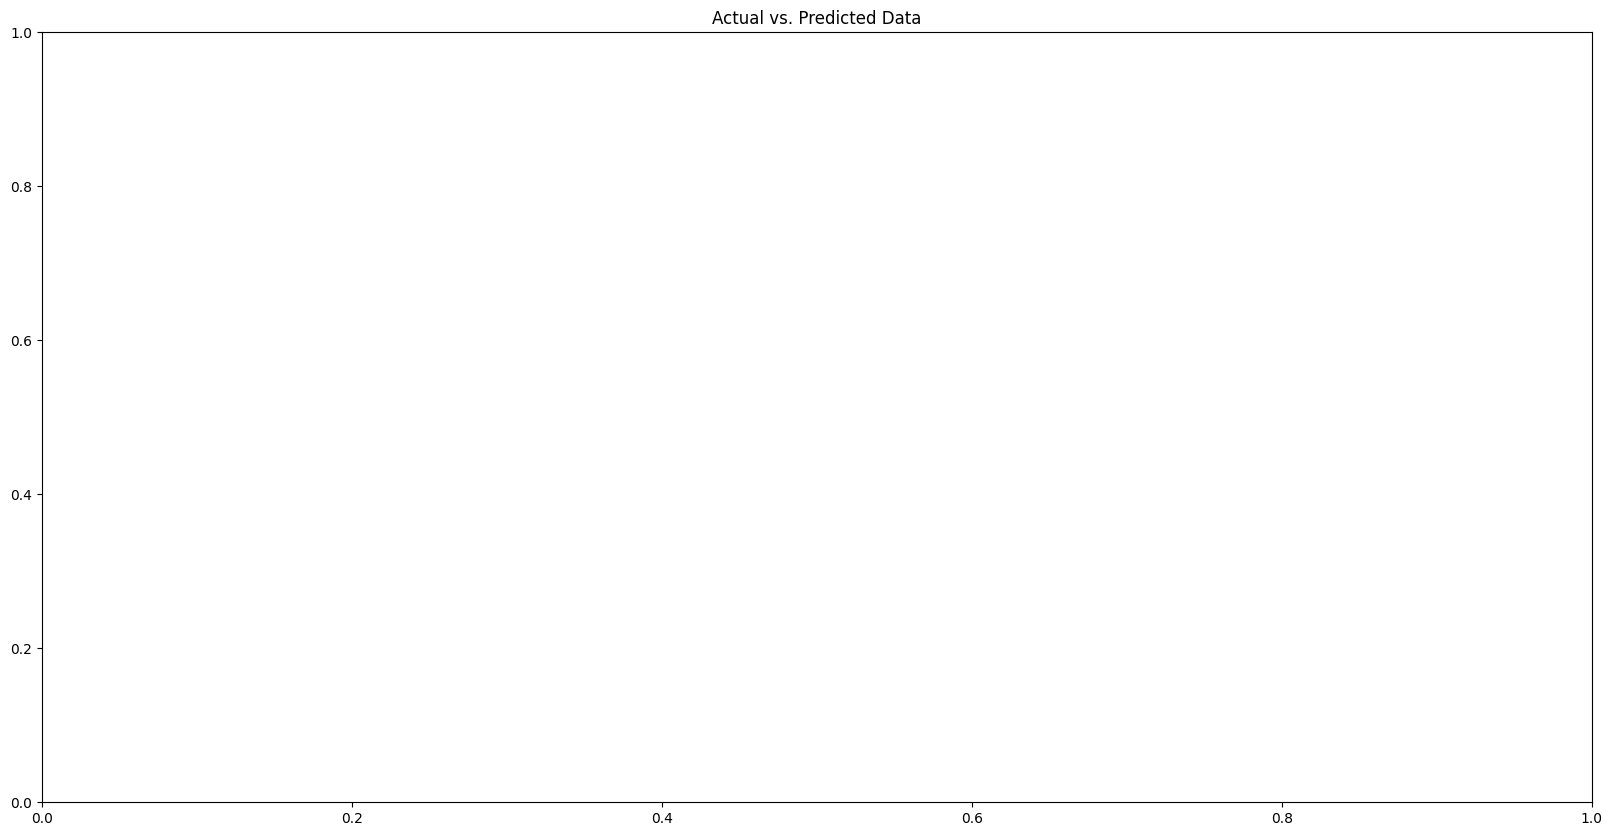

In [7]:
plt.figure(figsize=(20, 10))
plt.title('Actual vs. Predicted Data')
#plt.plot( raw_data['time'], test_data )
plt.plot( range(window_size,predicted_values.size), predicted_values, label="Predicted Data", color='red')
plt.xlabel('Dates')
plt.ylabel('Dollars')
plt.legend()
plt.show()